In [1]:
#TODO remove
#interesting code:
#: https://github.com/reeanne/FinalProject/blob/cef6b45060ad9646f2be4de93c226aebeadec41b/essentia-master/src/examples/python/streaming_extractor/tonaldescriptors.py
#https://github.com/LqNoob/Essentia/blob/7a70a25dd6668855b3677bd0cae0df190e319cbf/test/src/unittest/tonal/test_chordsdetection_streaming.py
#∫imple one https://github.com/mariogearth/ChordsDetectionPython/blob/b69e813bef92a361e7cad0a58bbd0f049b252914/old%20stuff/chords_test3.py

In [2]:
#Look at TODOs!!
#!pip3 install seaborn

In [3]:
import sys, os, re
import numpy as np
import pandas as pd
from collections import Counter
from collections import deque

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
%matplotlib inline

import essentia, essentia.standard, essentia.streaming
import essentia.standard as ess
from essentia.standard import BeatTrackerMultiFeature
from essentia.standard import ChordsDetectionBeats
from essentia.streaming import *

import mir_eval
import seaborn as sns
from pylab import savefig
import glob
from music21 import *
import json

In [4]:
'''
UTILS 
utils, inspired/copied from:
  https://github.com/seffka/ACE2017/blob/master/essentia_chord_utils.py

'''

def tuning(infile):
    hopSize = 2048
    frameSize = 8192
    loader = MonoLoader(filename=infile)
    framecutter = FrameCutter(hopSize=hopSize, frameSize=frameSize)
    windowing = Windowing(type="blackmanharris62")
    spectrum = Spectrum()
    spectralpeaks = SpectralPeaks(orderBy="frequency",
                                  magnitudeThreshold=1e-05,
                                  minFrequency=40,
                                  maxFrequency=5000,
                                  maxPeaks=10000)
    tuning = TuningFrequency()
    # use pool to store data
    pool = essentia.Pool()
    # connect algorithms together
    loader.audio >> framecutter.signal
    framecutter.frame >> windowing.frame >> spectrum.frame
    spectrum.spectrum >> spectralpeaks.spectrum
    spectralpeaks.magnitudes >> tuning.magnitudes
    spectralpeaks.frequencies >> tuning.frequencies
    tuning.tuningFrequency >> (pool, 'tonal.tuningFrequency')
    tuning.tuningCents >> (pool, 'tonal.tuningCents')
    # network is ready, run it
    print ('Processing audio file...', infile)
    essentia.run(loader)
    return np.average(pool['tonal.tuningFrequency'])

class ChordSegment :
    startTime = 0.0
    endTime = 0.0
    symbol = ''
    def __init__(self, startTime, endTime, symbol):
        self.startTime = startTime
        self.endTime = endTime
        self.symbol = symbol
    def __repr__(self):
        return str(self.startTime) + '\t' + str(self.endTime) + '\t' + self.symbol
    
def mergeSegments(chordSegments) :
    if (len(chordSegments) < 2) :
        return chordSegments
    res = []
    currentSegment = chordSegments[0]
    for segment in chordSegments[1:] :
        if (segment.symbol == currentSegment.symbol):
            currentSegment.endTime = segment.endTime
        else:
            res.append(currentSegment)
            currentSegment = segment
    res.append(currentSegment)
    return res

def convertChordLabels(chordSegments) :
    for segment in chordSegments :
        segment.symbol = re.sub('m$', ':min', segment.symbol)
    return chordSegments


def toMirexLab(startTime, endTime, onsets, symbols, strengths) :
    if (len(onsets) < len(symbols) or len(symbols) != len(strengths)) :
        raise ValueError("inappropriate lists lengths")
    if (len(onsets) == len(symbols)) :
        onsets = np.concatenate((onsets, [endTime]))
    res = []
    if (startTime < onsets[0]) :
        res.append(ChordSegment(startTime, onsets[0], 'N'))
    for i in range(len(symbols)) :
        sym = symbols[i] if strengths[i] > 0 else 'N'
        res.append(ChordSegment(onsets[i], onsets[i+1], sym))
    if (res[-1].endTime < endTime) :
        res.append(ChordSegment(res[-1].endTime, endTime, 'N'))
    return convertChordLabels(mergeSegments(res))


def processFiles(inputDir, outputDir, processFunction) :
    for file in [f for f in os.listdir(inputDir) if os.path.isfile(os.path.join(inputDir, f))] :
        name, ext = os.path.splitext(file)
        processFunction(os.path.join(inputDir, file), os.path.join(outputDir, name + '.lab'))

In [5]:
'''
Compute Chords by Frames in Essentia 
utils, inspired/copied from:
  https://github.com/seffka/ACE2017/blob/master/essentia_chord_utils.py

'''

def computeChordsByFrames(filename, outfile, frameSize=4096, hopSize=2048, tuningFrequency=440.0):

    #TODO:check pools https://essentia.upf.edu/documentation/essentia_python_tutorial.html 

    pool = essentia.Pool()
    loader = essentia.streaming.MonoLoader(filename=filename)
    
    #get the frames and compute chord detection
    fc = FrameCutter(frameSize=frameSize,
                     hopSize=hopSize,
                     silentFrames='noise')

    w = Windowing(type='blackmanharris62')
    spec = Spectrum()
    spectralpeaks = SpectralPeaks(orderBy="magnitude",
                                      magnitudeThreshold=1e-05,
                                      minFrequency=40,
                                      maxFrequency=5000,
                                      maxPeaks=10000)
    
    #TODO learn: https://essentia.upf.edu/documentation/reference/std_HPCP.html
    hpcp = HPCP(
        size=12,
        referenceFrequency = tuningFrequency,
        harmonics = 8,
        bandPreset = True,
        minFrequency = 40.0,
        maxFrequency = 5000.0,
        bandSplitFrequency = 250.0,
        weightType = "cosine",
        nonLinear = False,
        windowSize = 1.0,
        normalized='unitMax')
    
    #TODO: check parameters https://essentia.upf.edu/documentation/reference/std_ChordsDetection.html
    chords = ChordsDetection()
    chords_desc = ChordsDescriptors()


    # connect algorithms together
    loader.audio >> fc.signal
    fc.frame >> w.frame >> spec.frame
    spec.spectrum >> spectralpeaks.spectrum
    spec.spectrum >> (pool, 'spectrum.magnitude') #mine
    spectralpeaks.frequencies >> hpcp.frequencies
    spectralpeaks.magnitudes >> hpcp.magnitudes
    hpcp.hpcp >> (pool, 'chroma.hpcp')  #mine
    hpcp.hpcp >> chords.pcp
    chords.chords >> (pool, 'chords.chords')
    chords.strength >> (pool, 'chords.strength')

    essentia.run(loader)

    audio = essentia.standard.MonoLoader(filename = filename)()
    endTime = len(audio) / 44100.0
    stamps = np.arange(0, endTime, float(hopSize/44100.0))
    stamps = np.array([round(stamp,2) for stamp in stamps]) #2 decimals

    # workaround for Essentia behaviour I don't quite undestand: https://github.com/seffka/ACE2017/blob/467068d9667de43de8b8b8396e620d9e62a0d85c/essentia_chords.py
    syms = list(pool['chords.chords'][:-1])
    strengths = list(pool['chords.strength'][:-1])
    segments = toMirexLab(0.0, endTime, stamps, syms, strengths)
    with open(outfile, 'w') as content_file:
        for s in segments:
            content_file.write(str(s) + '\n')
    print("\n", outfile, " was written")

    
    spectrum= pool['spectrum.magnitude']
    chroma= pool['chroma.hpcp']
    chords= pool['chords.chords']
    chords_strength= pool['chords.strength']
    
    return spectrum, chroma, chords, chords_strength

In [6]:

def computeChordsByBeats(filename, outfile, hopSize=4096, frameSize=8192, tuningFrequency=440.0):
    
    # use pool to store data
    pool = essentia.Pool()
    # initialize algorithms we will use
    loader = MonoLoader(filename=filename)
    framecutter = FrameCutter(hopSize=hopSize, frameSize=frameSize)
    windowing = Windowing(type="blackmanharris62")
    spectrum = Spectrum()
    spectralpeaks = SpectralPeaks(orderBy="magnitude",
                                  magnitudeThreshold=1e-05,
                                  minFrequency=40,
                                  maxFrequency=5000,
                                  maxPeaks=10000)
    hpcp = HPCP(size=12,
                referenceFrequency = tuningFrequency,
                harmonics = 8,
                bandPreset = True,
                minFrequency = 40.0,
                maxFrequency = 5000.0,
                bandSplitFrequency = 500.0,
                weightType = "cosine",
                nonLinear = True,
                windowSize = 1.0)

    # connect algorithms together
    loader.audio >> framecutter.signal
    framecutter.frame >> windowing.frame >> spectrum.frame
    spectrum.spectrum >> spectralpeaks.spectrum
    spectralpeaks.magnitudes >> hpcp.magnitudes
    spectralpeaks.frequencies >> hpcp.frequencies
    hpcp.hpcp >> (pool, 'chroma.hpcp')

    essentia.run(loader)
    
    print('Loading audio file...', filename)
    audio = ess.MonoLoader(filename = filename)()
    bt = ess.BeatTrackerMultiFeature()
    beats, confidence = bt(audio)
    beats = np.array([round(beat,2) for beat in beats])
    
    #ticks = beats[::4] # TODO: should we take each 4 beats??
    print("number of beats", len(beats))

    computeChordsByBeats = ChordsDetectionBeats(hopSize=hopSize)
    chords, strengths = computeChordsByBeats(pool['chroma.hpcp'], beats)
    
    segments = toMirexLab(0.0, len(audio) / 44100.0, beats, chords, strengths)
    with open(outfile, 'w') as content_file:
        for s in segments:
            content_file.write(str(s) + '\n')
    print("\n", outfile, " was written")
    
    
    return chords, strengths, beats

In [7]:
def evaluateTriads(estimate_file, reference_file):
    '''
    expects .lab files
    performs mir_eval on triads
    return an object with '''
    (ref_intervals, ref_labels) = mir_eval.io.load_labeled_intervals(reference_file)
    (est_intervals, est_labels) = mir_eval.io.load_labeled_intervals(estimate_file)

    est_intervals, est_labels = mir_eval.util.adjust_intervals(
        est_intervals, est_labels, ref_intervals.min(),
        ref_intervals.max(), mir_eval.chord.NO_CHORD,
        mir_eval.chord.NO_CHORD)

    (intervals,
     ref_labels,
     est_labels) = mir_eval.util.merge_labeled_intervals(
        ref_intervals, ref_labels, est_intervals, est_labels)

    durations = mir_eval.util.intervals_to_durations(intervals)
    comparisons = mir_eval.chord.triads(ref_labels, est_labels)
    score = mir_eval.chord.weighted_accuracy(comparisons, durations)
    
    #create a result object and save all that might be handy
    class Object(object):
        pass
    
    result = Object()
    result.durations = durations
    result.comparisons = comparisons
    result.score = score
    result.intervals = intervals
    result.ref_labels = ref_labels
    result.est_labels = est_labels

    return result

In [8]:
def evaluate_track(track_path):
    '''
    Process the track with chord by frames and by beats, perform mir_eval and return evaluation for both methods
    '''
    references_path = './ref_labs/'
    estimated_chord_beat_path = './estimated_chordBeat_labs/'
    estimated_chord_frame_path = './estimated_chordFrame_labs/'
    
    #get the .lab filepath
    track_name = os.path.basename(track_path)
    lab_name = os.path.splitext(track_name)[0] + '.lab'

    #filenames
    reference_lab = references_path + lab_name
    estimated_chordBeat_lab = estimated_chord_beat_path + lab_name
    estimated_chordFrame_lab = estimated_chord_frame_path + lab_name

    #create lab files
    song_tuning = tuning(track_path)
    computeChordsByBeats(track_path, estimated_chordBeat_lab, tuningFrequency=song_tuning)
    computeChordsByFrames(track_path, estimated_chordFrame_lab, tuningFrequency=song_tuning)

    #evaluate chord By Beat
    beat_mir_eval_result = evaluateTriads(estimated_chordBeat_lab, reference_lab)

    #evaluate chords By Frame
    frame_mir_eval_result = evaluateTriads(estimated_chordFrame_lab, reference_lab)
    
    return beat_mir_eval_result, frame_mir_eval_result

In [9]:
#Covert dictionary into dataframes
def convert_dict(dict_comparelabels, dict_foreachchord):
    #pd_rank: count and rank mistakes, the first line is the most common mistake
    pd_rank = pd.DataFrame.from_dict(dict_comparelabels, orient = 'index')
    pd_rank = pd_rank.reset_index(drop = False)
    pd_rank.columns = ['chord pairs', 'count']
    pd_rank = pd_rank.sort_values(by=['count'], ascending=False)
    
    #pd_compareeach: count and rank mistakes for every single chord
    pd_compareeach = pd.DataFrame.from_dict(dict_foreachchord, orient = 'index')

    return pd_rank, pd_compareeach


In [10]:
#Making a heatmap for mistakes the algorithm has made
def makeheatmap(pd_makeheatmap):
    plt.subplots(figsize=(20,15))
    svm = sns.heatmap(pd_makeheatmap, annot=True, fmt=".0f", cmap="YlGnBu")
    #print("x axis is estimated chords, y axis is the ground truth")
    figure = svm.get_figure()
    plt.show()
    return figure

In [12]:
#Count label pairs(the ones that's wrongly detected, and sort them
#dict_comparelabels: overall; dict_foreachchord: count mistakes for each chord
def Count_for_song(ref_labels, comparisons, est_labels):

    dict_comparelabels = dict()
    dict_foreachchord = dict()

    for i in range(len(ref_labels)):
        #If there is no mistake, continue
        if comparisons[i] == 1: 
            continue
        #Count overall mistakes
        temp = [ref_labels[i], est_labels[i]] #[ground truth, estimated]
        tempstr = str(temp)
        if tempstr not in dict_comparelabels:
            dict_comparelabels[tempstr] = 0
        dict_comparelabels[tempstr]+=1

        #Count for each chord
        if ref_labels[i] not in dict_foreachchord:
            dict_foreachchord[ref_labels[i]] = dict()
        if est_labels[i] not in dict_foreachchord[ref_labels[i]]:
            dict_foreachchord[ref_labels[i]][est_labels[i]] = 0
        dict_foreachchord[ref_labels[i]][est_labels[i]]+=1
        #Convert dictionaries into a dataframe
        most_common_errors, df_result = convert_dict(dict_comparelabels, dict_foreachchord)
    #Return the result(a big dataframe for a song)
    return df_result

The following function will find the most common mistakes for each chord(rank wrongly estimated chords by occurrence)

In [13]:
def find_mistakes_each_chord(pd_findmistake):
    temprow_names = []
    temprow_mistakes = []
    for rownum in range(0, len(pd_findmistake)):
        temprow = pd_findmistake.iloc[rownum]
        temprow = temprow.sort_values(ascending=False)
        temprow = temprow.dropna()
        #temprow.name is the current ground truth chord
        #temprow.index.values is the estimated chords
        #if you print temprow, it will print out the occurrence too
        temprow_names.append(temprow.name)
        temprow_mistakes.append(temprow.index.values)
        #print(temprow.name)
        #print(temprow.index.values)
    return temprow_names, temprow_mistakes


In [14]:
def One_song_analysis(pd_beat_single, pd_frame_single):
    
    print("Chosen_track_heatmap_by_beat")
    fig_beat_single = makeheatmap(pd_beat_single)
    pngname = 'chosen_song_beat.png'
    fig_beat_single.savefig(pngname, dpi=400)
        
    chordnames_beat, mistakes_beat = find_mistakes_each_chord(pd_beat_single)
    #Showing the most common mistakes for each chord
    for index_i in range(len(chordnames_beat)):
        print(chordnames_beat[index_i], mistakes_beat[index_i])

    print("Chosen_track_heatmap_by_frame")
    fig_frame_single = makeheatmap(pd_frame_single)
    pngname = 'chosen_song_frame.png'
    fig_frame_single.savefig(pngname, dpi=400)

    chordnames_frame, mistakes_frame = find_mistakes_each_chord(pd_frame_single)
    for index_i in range(len(chordnames_frame)):
        print(chordnames_frame[index_i], mistakes_frame[index_i])
    
    return
    

In [15]:
#TODO: KeyError: '7/3', if the function can't calculate distance for given chord pairs, print a message.
#TODO2: if distance >=7: return the number minus 7?
def compute_chords_note_difference(truth_chord, est_chord):
    '''
    Compute how similar are the mistakes: do the mistaken chords share a lot of notes,
    or are they very different between them?
     Note: we are aware that this might be a naive approach, but we think it is relevant to check if chords 
     that are mistaken often share many notes.
    '''

    chord_qualities = {
        #           1     2     3     4  5     6     7
        'maj':     [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        'min':     [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        'aug':     [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
        'dim':     [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
        'sus4':    [1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
        'sus2':    [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        '7':       [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        'maj7':    [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
        'min7':    [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        'minmaj7': [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
        'maj6':    [1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0],
        'min6':    [1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0],
        'dim7':    [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
        'hdim7':   [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0],
        'maj9':    [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
        'min9':    [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        '9':       [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        'b9':      [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        '#9':      [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        'min11':   [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        '11':      [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        '#11':     [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        'maj13':   [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
        'min13':   [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        '13':      [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        'b13':     [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        '1':       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        '5':       [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        '':        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


    def get_root(chord):
        '''returns the root of the chord'''
        try: 
            chord.index(':')       
            return chord[0: chord.index(':')]
        except: 
            return chord


    def get_chord_type(chord):
        '''returns the chord type'''
        try: 
            chord.index(':')       
            return chord[chord.index(':')+1:]
        except: 
            return 'maj'


    def get_notes_disposition(chord):
        '''
        will return a 12-note array with the note disposition for a chord
        example: for a '7' return [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0]
        '''
        return chord_qualities[get_chord_type(chord)]


    def transpose_disposition(dispostion, interval_semitones):
        '''will tranpose(shift) the given disposition the given interval semitones'''    
        items = deque(dispostion)
        items.rotate(interval_semitones)
        return list(items)


    def difference(li1, li2):
        '''counts the different items in two list of the same size'''
        diff_count = 0
        for i in range(len(li1)):
            if li1[i] != li2[i]: diff_count +=1
        return diff_count

    #compute note disposition for each chord:
    truth_disposition = get_notes_disposition(truth_chord)
    estimated_disposition = get_notes_disposition(est_chord)


    #compute distance in semitones between truth and estimation
    truth_root = note.Note(get_root(truth_chord))
    est_root = note.Note(get_root(est_chord))
    interval_semitones = interval.notesToChromatic(truth_root, est_root).semitones

    #we need to transpose the estimated chord to the same root as the ground truth:
    transposed_estimated_disposition = transpose_disposition(estimated_disposition, interval_semitones)

    #now can compare the note disposition between both and count how many different notes
    different_notes = difference(truth_disposition, transposed_estimated_disposition)
    return different_notes
    
    

print(compute_chords_note_difference('Eb:7', 'Ab'))

5


Processing audio file... ./audios_same_name/airegin.flac
Loading audio file... ./audios_same_name/airegin.flac
number of beats 474

 ./estimated_chordBeat_labs/airegin.lab  was written

 ./estimated_chordFrame_labs/airegin.lab  was written
Processing audio file... ./audios_same_name/all_alone.flac
Loading audio file... ./audios_same_name/all_alone.flac
number of beats 298

 ./estimated_chordBeat_labs/all_alone.lab  was written

 ./estimated_chordFrame_labs/all_alone.lab  was written
Processing audio file... ./audios_same_name/giant_steps.flac
Loading audio file... ./audios_same_name/giant_steps.flac
number of beats 687

 ./estimated_chordBeat_labs/giant_steps.lab  was written

 ./estimated_chordFrame_labs/giant_steps.lab  was written
Chosen_track_heatmap_by_beat


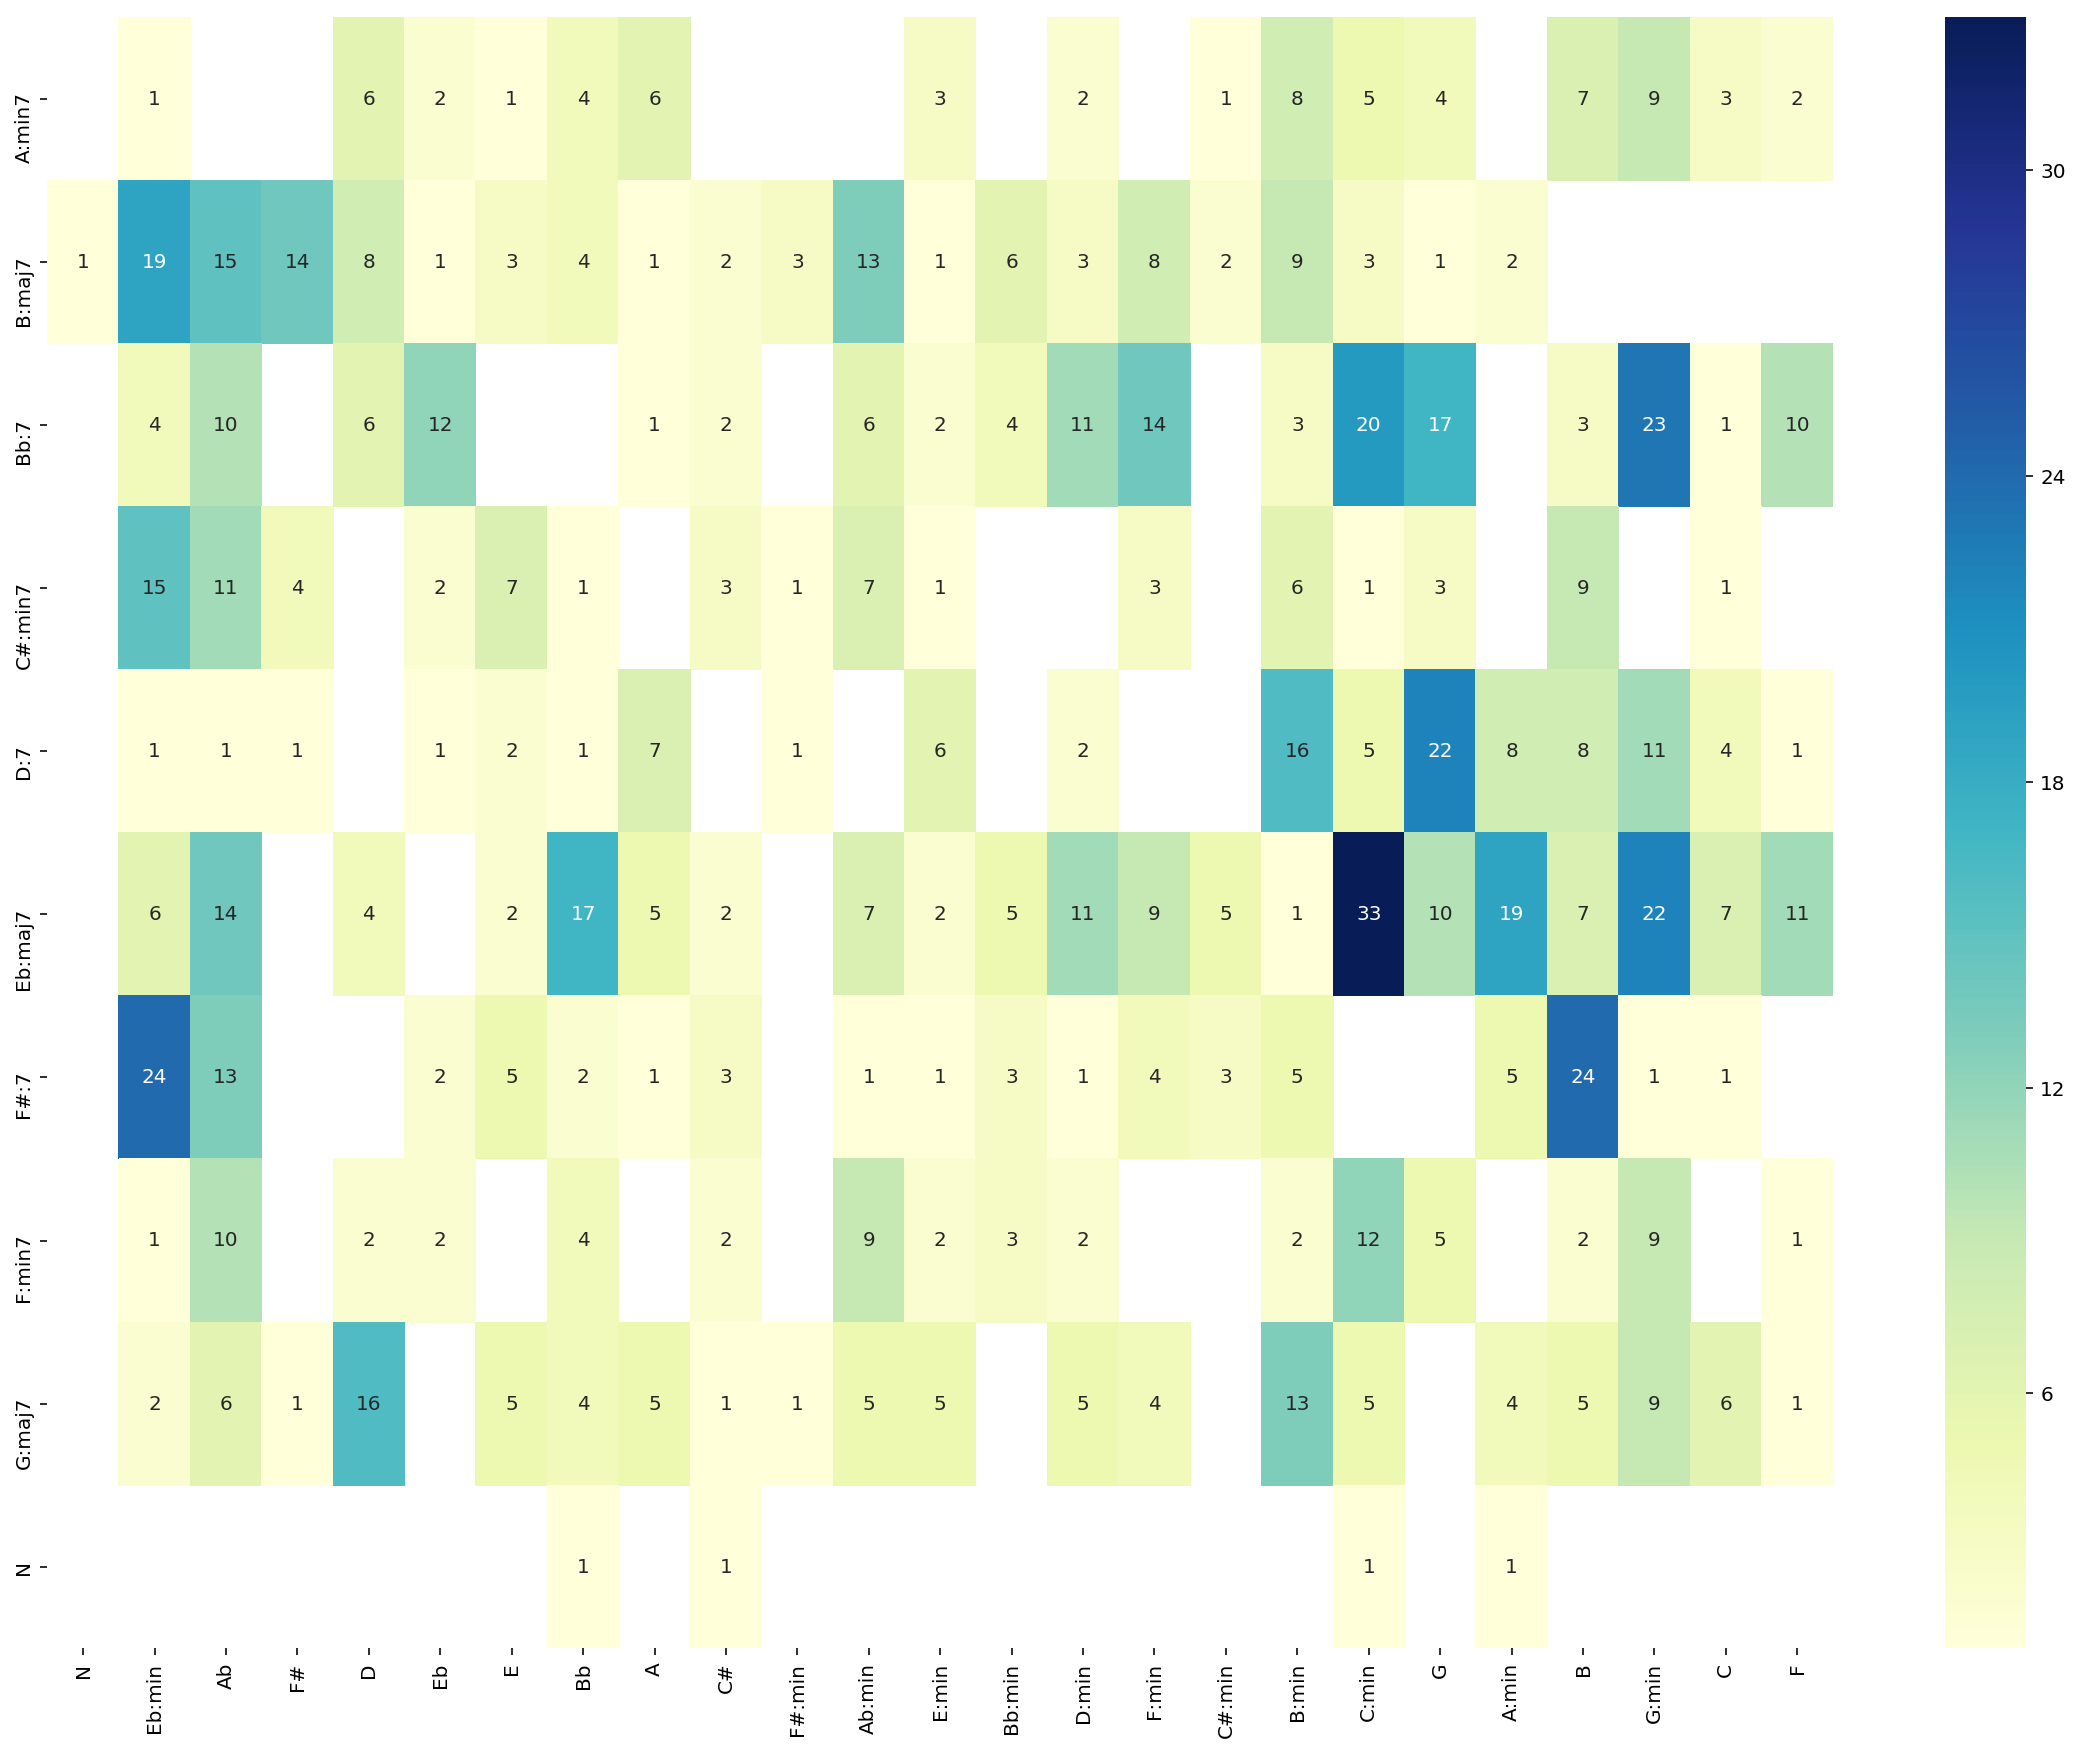

A:min7 ['G:min' 'B:min' 'B' 'A' 'D' 'C:min' 'G' 'Bb' 'C' 'E:min' 'F' 'D:min' 'Eb'
 'C#:min' 'E' 'Eb:min']
B:maj7 ['Eb:min' 'Ab' 'F#' 'Ab:min' 'B:min' 'F:min' 'D' 'Bb:min' 'Bb' 'F#:min'
 'C:min' 'D:min' 'E' 'A:min' 'C#' 'C#:min' 'A' 'Eb' 'G' 'E:min' 'N']
Bb:7 ['G:min' 'C:min' 'G' 'F:min' 'Eb' 'D:min' 'F' 'Ab' 'Ab:min' 'D' 'Bb:min'
 'Eb:min' 'B:min' 'B' 'E:min' 'C#' 'A' 'C']
C#:min7 ['Eb:min' 'Ab' 'B' 'Ab:min' 'E' 'B:min' 'F#' 'G' 'F:min' 'C#' 'Eb' 'C'
 'C:min' 'E:min' 'F#:min' 'Bb']
D:7 ['G' 'B:min' 'G:min' 'B' 'A:min' 'A' 'E:min' 'C:min' 'C' 'D:min' 'E' 'Eb'
 'Ab' 'F#' 'F' 'Bb' 'F#:min' 'Eb:min']
Eb:maj7 ['C:min' 'G:min' 'A:min' 'Bb' 'Ab' 'F' 'D:min' 'G' 'F:min' 'C' 'Ab:min'
 'B' 'Eb:min' 'C#:min' 'Bb:min' 'A' 'D' 'E:min' 'C#' 'E' 'B:min']
F#:7 ['Eb:min' 'B' 'Ab' 'A:min' 'B:min' 'E' 'F:min' 'C#:min' 'Bb:min' 'C#' 'Bb'
 'Eb' 'C' 'A' 'Ab:min' 'G:min' 'D:min' 'E:min']
F:min7 ['C:min' 'Ab' 'G:min' 'Ab:min' 'G' 'Bb' 'Bb:min' 'B' 'B:min' 'D:min'
 'E:min' 'C#' 'Eb' 'D' 'F' 'Eb:min']
G:maj7 ['

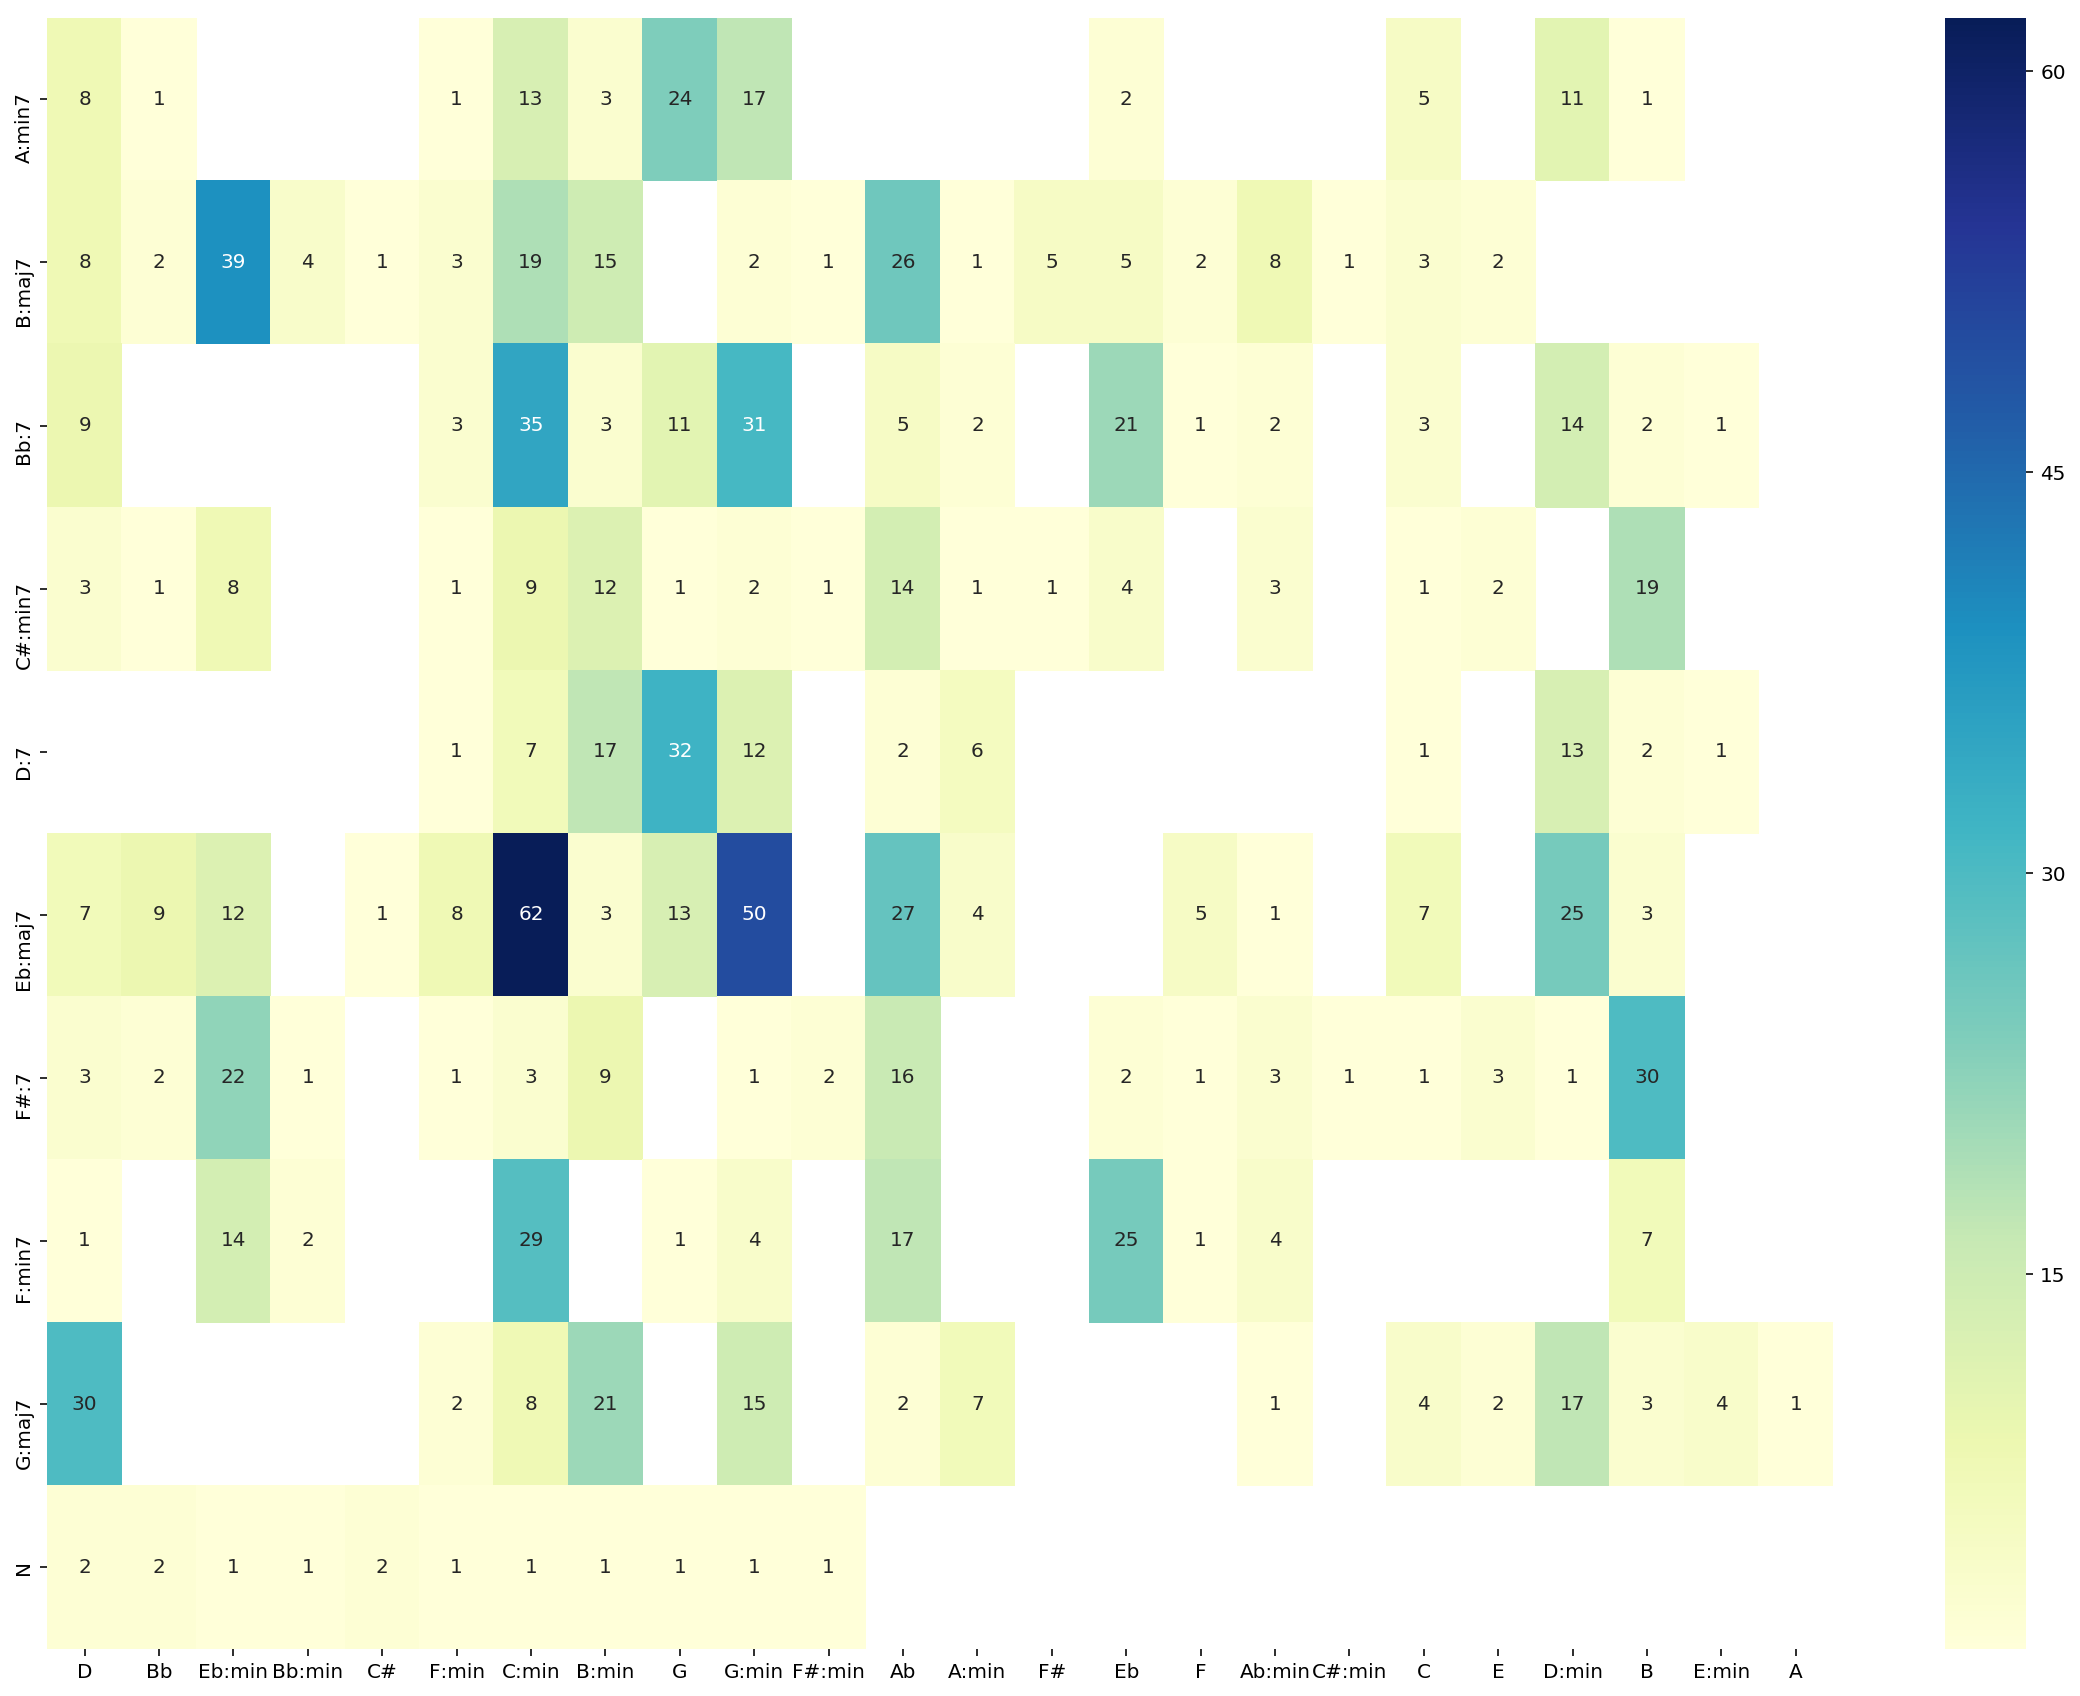

A:min7 ['G' 'G:min' 'C:min' 'D:min' 'D' 'C' 'B:min' 'Eb' 'B' 'F:min' 'Bb']
B:maj7 ['Eb:min' 'Ab' 'C:min' 'B:min' 'D' 'Ab:min' 'Eb' 'F#' 'Bb:min' 'C' 'F:min'
 'Bb' 'E' 'G:min' 'F' 'C#' 'A:min' 'C#:min' 'F#:min']
Bb:7 ['C:min' 'G:min' 'Eb' 'D:min' 'G' 'D' 'Ab' 'C' 'B:min' 'F:min' 'B'
 'Ab:min' 'A:min' 'E:min' 'F']
C#:min7 ['B' 'Ab' 'B:min' 'C:min' 'Eb:min' 'Eb' 'D' 'Ab:min' 'E' 'G:min' 'A:min'
 'G' 'F#' 'F:min' 'C' 'Bb' 'F#:min']
D:7 ['G' 'B:min' 'D:min' 'G:min' 'C:min' 'A:min' 'B' 'Ab' 'E:min' 'C' 'F:min']
Eb:maj7 ['C:min' 'G:min' 'Ab' 'D:min' 'G' 'Eb:min' 'Bb' 'F:min' 'C' 'D' 'F'
 'A:min' 'B' 'B:min' 'Ab:min' 'C#']
F#:7 ['B' 'Eb:min' 'Ab' 'B:min' 'C:min' 'D' 'Ab:min' 'E' 'Eb' 'Bb' 'F#:min' 'F'
 'D:min' 'G:min' 'C#:min' 'C' 'F:min' 'Bb:min']
F:min7 ['C:min' 'Eb' 'Ab' 'Eb:min' 'B' 'Ab:min' 'G:min' 'Bb:min' 'F' 'G' 'D']
G:maj7 ['D' 'B:min' 'D:min' 'G:min' 'C:min' 'A:min' 'E:min' 'C' 'B' 'E' 'Ab'
 'F:min' 'A' 'Ab:min']
N ['C#' 'Bb' 'D' 'F#:min' 'G:min' 'G' 'B:min' 'C:min' 'F:min' 'Bb:min'


In [16]:
#MAIN FUNCTION
audios_path = './audios_same_name/'

#get all audio track paths
all_audio_tracks = glob.glob(audios_path + '*.flac', recursive = True)
num_tracks = len(all_audio_tracks)

dict_comparelabels_beat_all = dict()
dict_comparelabels_frame_all = dict()
dict_foreachchord_beat_all = dict()
dict_foreachchord_frame_all = dict()
beat_overall_score = 0
frame_overall_score = 0
    
for track in all_audio_tracks:
    
    beat_mir_eval_result, frame_mir_eval_result = evaluate_track(track)
    
    #############
    #For beat algorithm, evaluate and put the detection mistakes into two big dictionaries
    #############
    
    #Get reference_labels(chord names), comparisons(if 1, no mistake), estimation labels(chord names), score for the current song
    beat_ref_labels = beat_mir_eval_result.ref_labels
    beat_comparisons = beat_mir_eval_result.comparisons
    beat_est_labels = beat_mir_eval_result.est_labels
    beat_score = beat_mir_eval_result.score
    beat_overall_score += beat_score
        
    for i in range(len(beat_ref_labels)):
        #If there is no mistake, continue
        if beat_comparisons[i] == 1: 
            continue
        #Count overall mistakes
        temp = [beat_ref_labels[i], beat_est_labels[i]] #[ground truth, estimated]
        tempstr = str(temp)
        if tempstr not in dict_comparelabels_beat_all:
            dict_comparelabels_beat_all[tempstr] = 0
        dict_comparelabels_beat_all[tempstr]+=1

        #Count for each chord
        if beat_ref_labels[i] not in dict_foreachchord_beat_all:
            dict_foreachchord_beat_all[beat_ref_labels[i]] = dict()
        if beat_est_labels[i] not in dict_foreachchord_beat_all[beat_ref_labels[i]]:
            dict_foreachchord_beat_all[beat_ref_labels[i]][beat_est_labels[i]] = 0
        dict_foreachchord_beat_all[beat_ref_labels[i]][beat_est_labels[i]]+=1
    
    #############
    #For frame algorithm, evaluate and put the detection mistakes into two big dictionaries
    #############
    
    frame_ref_labels = frame_mir_eval_result.ref_labels
    frame_comparisons = frame_mir_eval_result.comparisons
    frame_est_labels = frame_mir_eval_result.est_labels
    frame_score = frame_mir_eval_result.score
    frame_overall_score += frame_score
    
    for i in range(len(frame_ref_labels)):
        #If there is no mistake, continue
        if frame_comparisons[i] == 1: 
            continue
        #Count overall mistakes
        temp = [frame_ref_labels[i], frame_est_labels[i]] #[ground truth, estimated]
        tempstr = str(temp)
        if tempstr not in dict_comparelabels_frame_all:
            dict_comparelabels_frame_all[tempstr] = 0
        dict_comparelabels_frame_all[tempstr]+=1

        #Count for each chord
        if frame_ref_labels[i] not in dict_foreachchord_frame_all:
            dict_foreachchord_frame_all[frame_ref_labels[i]] = dict()
        if frame_est_labels[i] not in dict_foreachchord_frame_all[frame_ref_labels[i]]:
            dict_foreachchord_frame_all[frame_ref_labels[i]][frame_est_labels[i]] = 0
        dict_foreachchord_frame_all[frame_ref_labels[i]][frame_est_labels[i]]+=1
    
    chosen_track = audios_path+"giant_steps.flac"
    #Generate heatmap and array of top errors for one song
    if track == chosen_track:
        pd_beat_single = Count_for_song(beat_ref_labels, beat_comparisons, beat_est_labels)
        pd_frame_single = Count_for_song(frame_ref_labels, frame_comparisons, frame_est_labels)
        One_song_analysis(pd_beat_single, pd_frame_single)
    

Analyze chord detection algorithm by beat:

In [17]:
beat_overall_score_mean = beat_overall_score/num_tracks
print("Overall accuracy of chord detection by beat: ", beat_overall_score_mean)


Overall accuracy of chord detection by beat:  0.22010931682556759


In [18]:
#Overall top 10 errors for algorithm by beat
rank_beat, df_result_beat = convert_dict(dict_comparelabels_beat_all, dict_foreachchord_beat_all)

#rank_beat.head(5)

with open('Top_errors_overall_beat.txt', 'w') as outfile:
    for rownum in range(0, 11):
        temprow = rank_beat.iloc[rownum]
        outfile.write(temprow["chord pairs"])
        outfile.write(str(temprow["count"])+'\n')


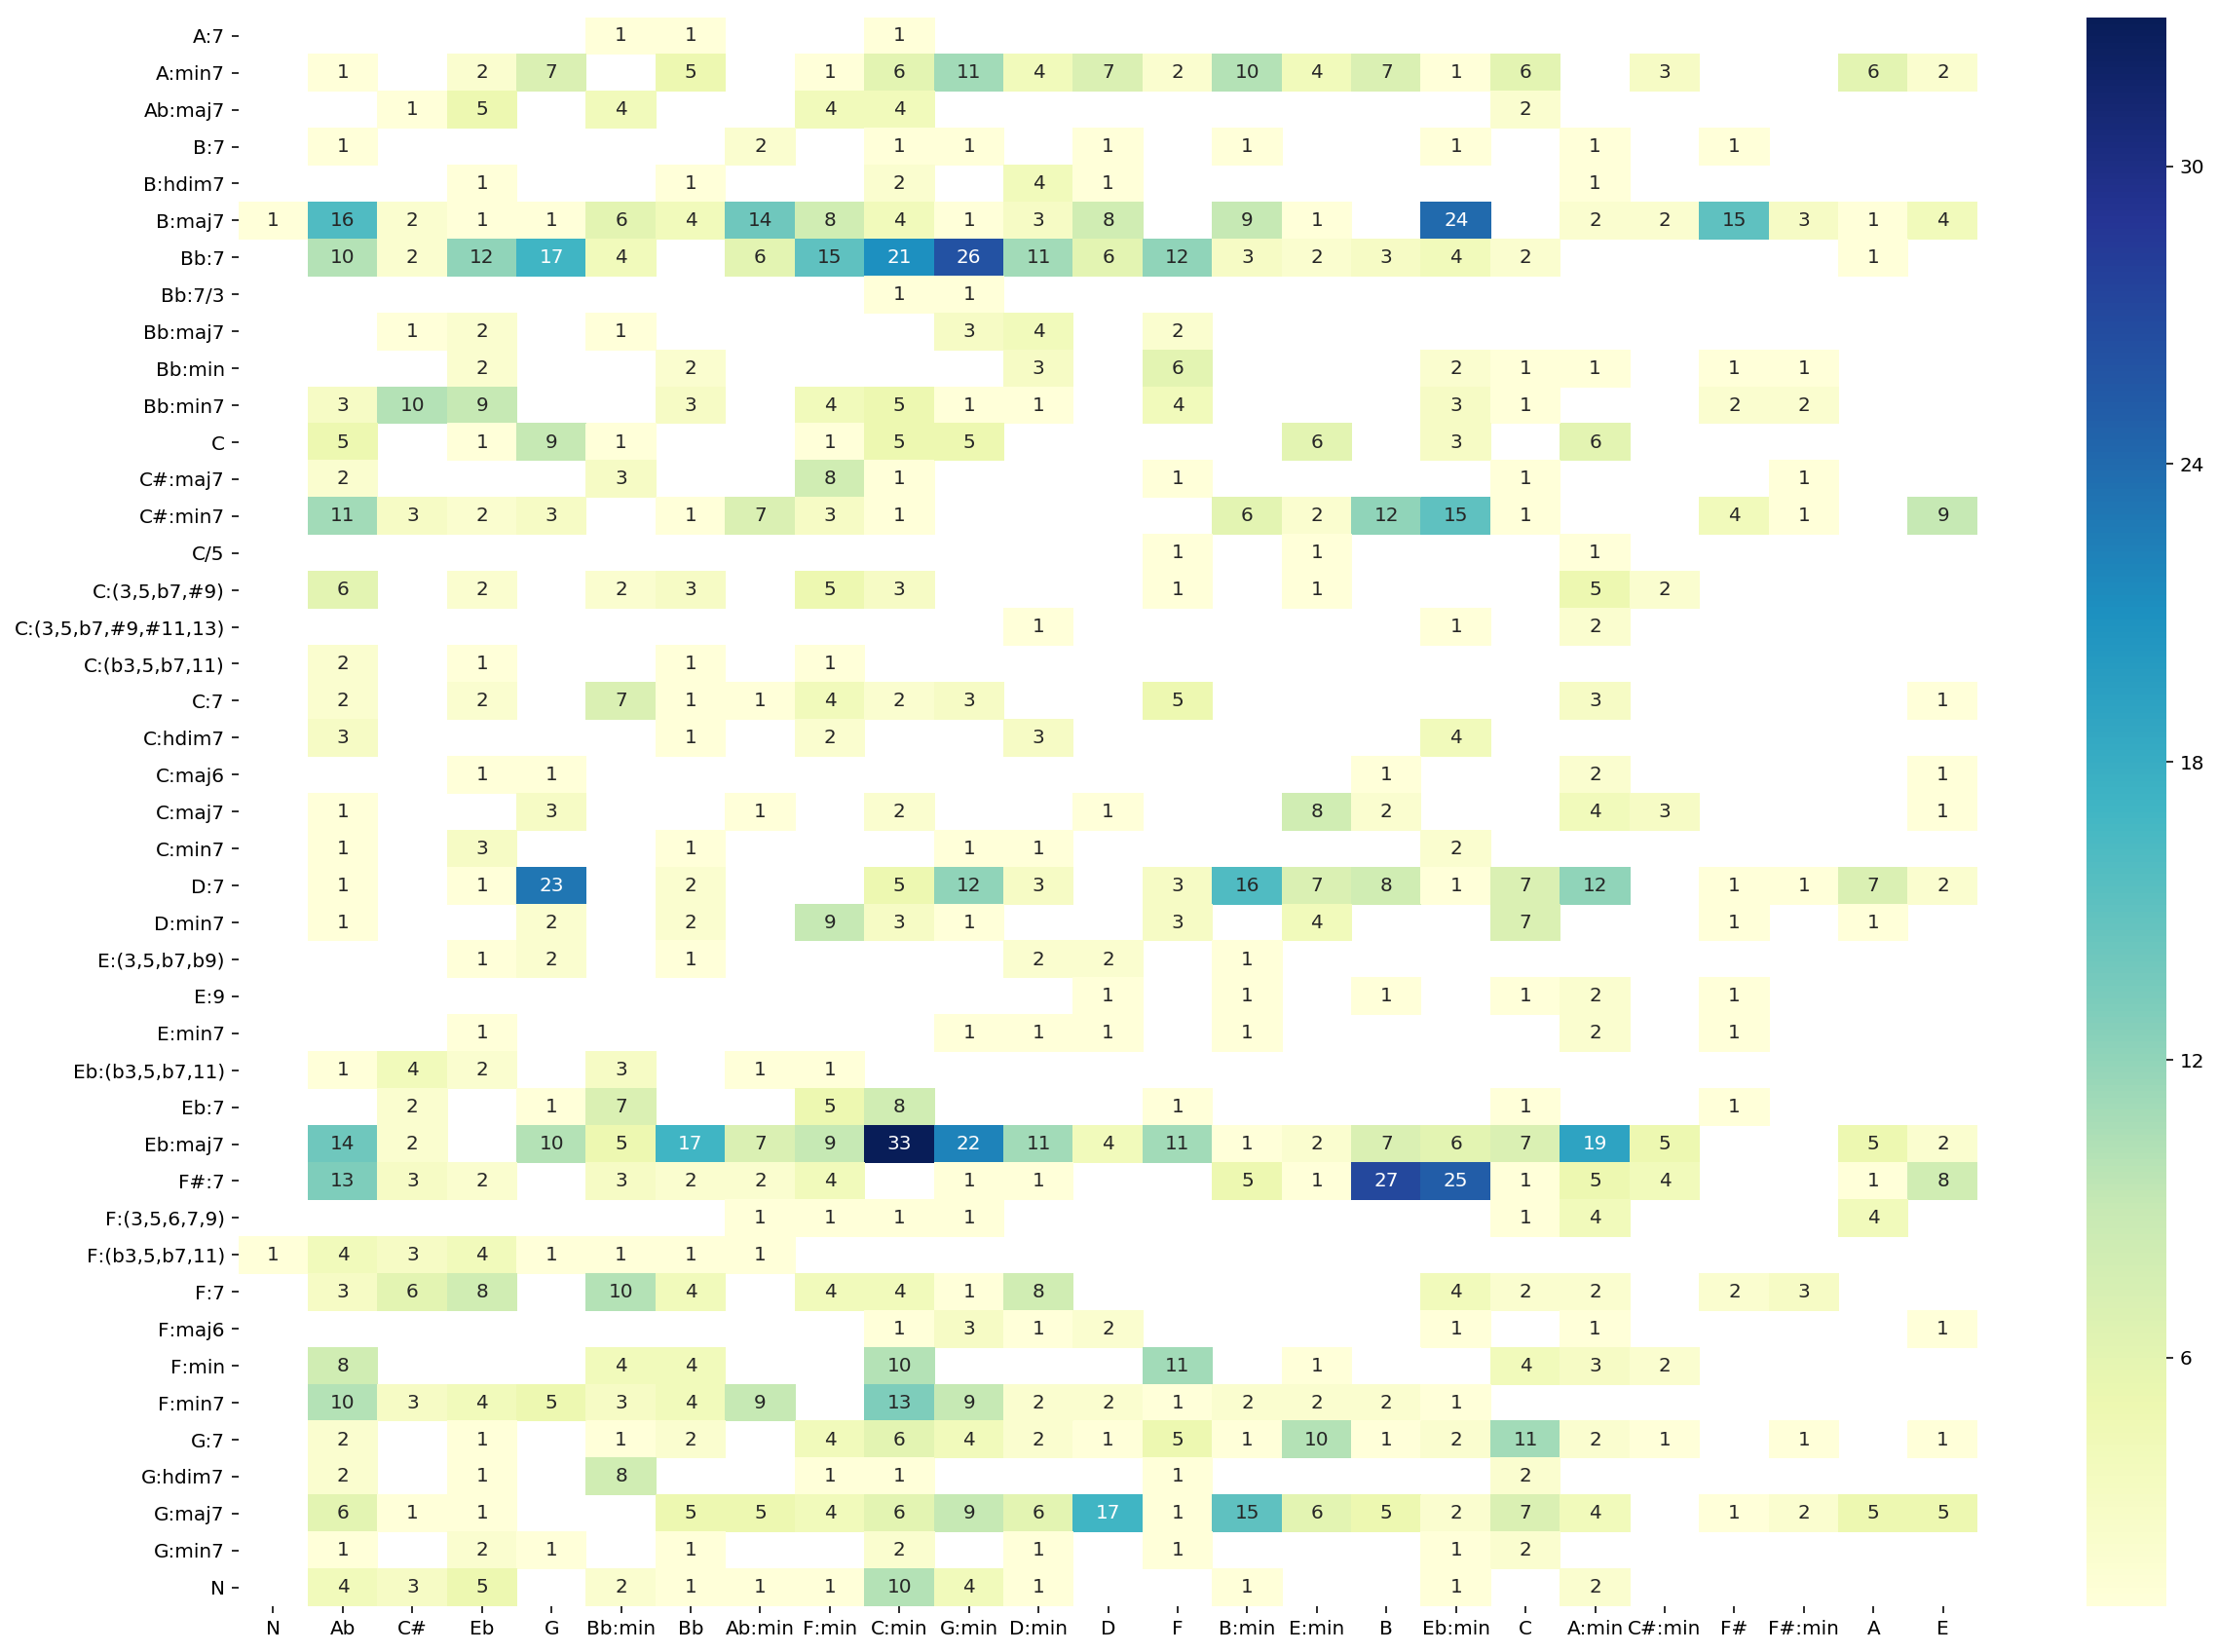

In [19]:
figure_beat = makeheatmap(df_result_beat)
figure_beat.savefig('heatmap_beat.png', dpi=400)

In [20]:
chordnames_beat_all, mistakes_beat_all = find_mistakes_each_chord(df_result_beat)
with open('Top_errors_for_each_chord_beat.txt', 'w') as outfile:
    for j in range(len(chordnames_beat_all)):
        ##Output as json format
        #json.dump(chordnames_beat_all[j], outfile)
        #json.dump(str(mistakes_beat_all[j]), outfile)
        ##Output as txt format
        outfile.write(chordnames_beat_all[j]+'\n')
        outfile.write(str(mistakes_beat_all[j])+'\n')
        print(chordnames_beat_all[j], mistakes_beat_all[j])

A:7 ['C:min' 'Bb' 'Bb:min']
A:min7 ['G:min' 'B:min' 'D' 'B' 'G' 'C' 'A' 'C:min' 'Bb' 'E:min' 'D:min' 'C#:min'
 'Eb' 'E' 'F' 'F:min' 'Eb:min' 'Ab']
Ab:maj7 ['Eb' 'C:min' 'F:min' 'Bb:min' 'C' 'C#']
B:7 ['Ab:min' 'F#' 'A:min' 'Eb:min' 'B:min' 'D' 'G:min' 'C:min' 'Ab']
B:hdim7 ['D:min' 'C:min' 'A:min' 'D' 'Bb' 'Eb']
B:maj7 ['Eb:min' 'Ab' 'F#' 'Ab:min' 'B:min' 'F:min' 'D' 'Bb:min' 'C:min' 'Bb' 'E'
 'D:min' 'F#:min' 'A:min' 'C#' 'C#:min' 'Eb' 'G:min' 'G' 'A' 'E:min' 'N']
Bb:7 ['G:min' 'C:min' 'G' 'F:min' 'Eb' 'F' 'D:min' 'Ab' 'D' 'Ab:min' 'Bb:min'
 'Eb:min' 'B:min' 'B' 'C' 'E:min' 'C#' 'A']
Bb:7/3 ['G:min' 'C:min']
Bb:maj7 ['D:min' 'G:min' 'F' 'Eb' 'Bb:min' 'C#']
Bb:min ['F' 'D:min' 'Eb:min' 'Bb' 'Eb' 'F#:min' 'F#' 'A:min' 'C']
Bb:min7 ['C#' 'Eb' 'C:min' 'F' 'F:min' 'Eb:min' 'Bb' 'Ab' 'F#:min' 'F#' 'C'
 'D:min' 'G:min']
C ['G' 'A:min' 'E:min' 'G:min' 'C:min' 'Ab' 'Eb:min' 'F:min' 'Bb:min' 'Eb']
C#:maj7 ['F:min' 'Bb:min' 'Ab' 'F#:min' 'C' 'F' 'C:min']
C#:min7 ['Eb:min' 'B' 'Ab' 'E' 'Ab:min' '

In [21]:
'''
index = 0
for chordname in chordnames_beat_all:
    print("current chordname:")
    print(chordname)
    if chordname == 'N':
        print("Can't compute distance for N")
        continue
    for mistake in mistakes_beat_all[index]:
        print("current mistake:")
        print(mistake)
        if mistake == 'N':
            print("Can't compute distance for N")
            continue
        print("distance:")
        #TODO: KeyError: '7/3', if the function can't calculate distance for given chord pairs, print a message.
        print(compute_chords_note_difference(chordname, mistake))
    index+=1
'''

current chordname:
A:7
current mistake:
C:min
distance:
5
current mistake:
Bb
distance:
7
current mistake:
Bb:min
distance:
5
current chordname:
A:min7
current mistake:
G:min
distance:
5
current mistake:
B:min
distance:
7
current mistake:
D
distance:
5
current mistake:
B
distance:
7
current mistake:
G
distance:
5
current mistake:
C
distance:
1
current mistake:
A
distance:
3
current mistake:
C:min
distance:
3
current mistake:
Bb
distance:
7
current mistake:
E:min
distance:
3
current mistake:
D:min
distance:
5
current mistake:
C#:min
distance:
5
current mistake:
Eb
distance:
5
current mistake:
E
distance:
5
current mistake:
F
distance:
3
current mistake:
F:min
distance:
5
current mistake:
Eb:min
distance:
7
current mistake:
Ab
distance:
5
current chordname:
Ab:maj7
current mistake:
Eb
distance:
3
current mistake:
C:min
distance:
1
current mistake:
F:min
distance:
3
current mistake:
Bb:min
distance:
7
current mistake:
C
distance:
3
current mistake:
C#
distance:
5
current chordname:
B:7
cu

KeyError: '7/3'

Analyze chord detection algorithm by frame:

In [ ]:
frame_overall_score_mean = frame_overall_score/num_tracks    
print("Overall accuracy of chord detection by frame: ", frame_overall_score_mean)

In [ ]:
#Overall top 10 errors for algorithm by frame
rank_frame, df_result_frame = convert_dict(dict_comparelabels_frame_all, dict_foreachchord_frame_all)

with open('Top_errors_overall_frame.txt', 'w') as outfile:
    for rownum in range(0, 11):
        temprow = rank_frame.iloc[rownum]
        outfile.write(temprow["chord pairs"])
        outfile.write(str(temprow["count"])+'\n')


In [ ]:
figure_frame = makeheatmap(df_result_frame)
figure_frame.savefig('heatmap_frame.png', dpi=400)

In [ ]:
chordnames_frame_all, mistakes_frame_all = find_mistakes_each_chord(df_result_frame)
with open('Top_errors_for_each_chord_frame.txt', 'w') as outfile:
    for j in range(len(chordnames_frame_all)):
        ##Output as json format
        #json.dump(chordnames_frame_all[j], outfile)
        #json.dump(str(mistakes_frame_all[j]), outfile)
        ##Output as txt format
        outfile.write(chordnames_frame_all[j]+'\n')
        outfile.write(str(mistakes_frame_all[j])+'\n')
        print(chordnames_frame_all[j], mistakes_frame_all[j])

In [ ]:
'''
index = 0
for chordname in chordnames_frame_all:
    print("current chordname:")
    print(chordname)
    if chordname == 'N':
        print("Can't compute distance for N")
        continue
    for mistake in mistakes_frame_all[index]:
        print("current mistake:")
        print(mistake)
        if mistake == 'N':
            print("Can't compute distance for N")
            continue
        print("distance:")
        #TODO: KeyError: '7/3', if the function can't calculate distance for given chord pairs, print a message.
        print(compute_chords_note_difference(chordname, mistake))
    index+=1
'''

In [ ]:
'''
#scales
import json
json_path = './annotations/'

print(json_path)
print(len(os.listdir(json_path)))

keyDict = dict()
for file in os.listdir(json_path):
    file_path = os.path.join(json_path, file)
    print(file_path)
    with open(file_path, 'r') as f:
        loaded = json.load(f)
        if 'key' in loaded:
            key = loaded['key']
            print(key)
            if key not in keyDict:
                keyDict[key] = list()
            keyDict[key].append(file)
keyDict
'''
